# Scrapping de una página con login
Voy a intentar sacar datos de Moodle dado a que tiene unas url secuenciales y parece bastante simple y poco seguro de automatizar.

Tanto el archivo de salida como el txt con el ID de la cookie no se van a subir por motivos obvios

Para sacar el valor de la cookie, iniciar sesión en el sitio y con DevTools (F12) ir a "Aplicación" y en la sección de Cookies tiene que haber una cookie de sesión:
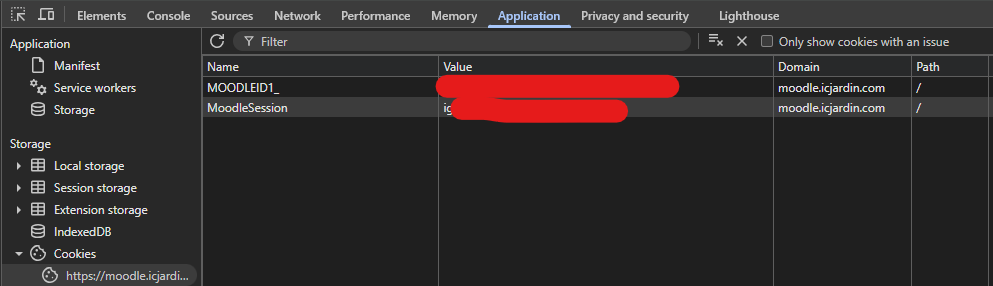

In [7]:
from pathlib import Path
import cloudscraper

scraper = cloudscraper.create_scraper()

# Path relativo al script
cookie_file = Path.cwd() / "cookie.txt"

# Leer el value de la cookie
with open(cookie_file) as f:
    session_value = f.read().strip()

scraper.cookies.set("MoodleSession", session_value, domain="moodle.icjardin.com", path="/")

r = scraper.get("https://moodle.icjardin.com/user/profile.php?id=1&showallcourses=1")
print(r.status_code)
print(r.text[:200])

200
<!DOCTYPE html>

<html  dir="ltr" lang="es" xml:lang="es">
<head>
    <title>Gonbidatua  : Perfil público | ICJ</title>
    <link rel="shortcut icon" href="https://moodle.icjardin.com/theme/image.php/


Con el 200 y la cabecera podemos ver hasta el nombre del primer perfil del sitio.

Vamos a hacer el esqueleto de los datos, el showallcourses es para desplegar los cursos del usuario, que es algo que quiero recopilar más adelante.

Con el DevTools vemos que la class "h2 mb-0" es unica y tiene el nombre del usuario. Vamos a sacarlo con bs4:

In [10]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(r.text, 'html.parser')

username = soup.find(class_="h2 mb-0")

print(username.text)

Gonbidatua  


Todas las tarjetas del usuario tienen la misma estructura, asi que extraer valor de ellas va a ser complicado.

Es complicado de identificar pero siempre tienen un <section> con clases "node_category card d-inline-block w-100 mb-3"

In [11]:
cards = soup.find_all(class_="node_category card d-inline-block w-100 mb-3")

for card in cards:
    print(card)

<section class="node_category card d-inline-block w-100 mb-3"><div class="card-body"><h3 class="lead">Detalles de usuario</h3><ul><li class="contentnode"><dl><dt>Zona horaria</dt><dd>Europe/Madrid</dd></dl></li></ul></div></section>
<section class="node_category card d-inline-block w-100 mb-3"><div class="card-body"><h3 class="lead">Actividad de accesos</h3><ul><li class="contentnode"><dl><dt>Primer acceso al sitio</dt><dd>Nunca</dd></dl></li><li class="contentnode"><dl><dt>Último acceso al sitio</dt><dd>Nunca</dd></dl></li></ul></div></section>


Podemos filtrar el tipo de tarjeta por el h3 hijo que indica en formato titulo su contenido. Quiero todos los cursos de este usuario que si que tiene un listado:

In [ ]:
r2 = scraper.get("https://moodle.icjardin.com/user/profile.php?id=4&showallcourses=1")

soup2 = BeautifulSoup(r2.text, 'html.parser')

cards = soup2.find_all(class_="node_category card d-inline-block w-100 mb-3")

for card in cards:
    if card.find("h3").text == "Detalles del curso":
        cursos = card.find_all("a") # Saca todos los enlaces
        for i,curso in enumerate(cursos): # Uso enumerate para contar iteraciones, quiero hacer una preview por privacidad
            print(curso.text) # Tag.text limpia la tag y extrae solo texto, quita mucha morralla de los enlaces
            if i > 3:
                break # Para la lista completa quitar logica de break


Kalitatea / Calidad
Jefatura de Estudios 
Moodle dokumentazioa (TKnika)
Departamento de Orientación
ETHAZI


Puedo filtrar la fecha de creacion y ultima hora de conexion tambien:

In [21]:
for card in cards:
    if card.find("h3").text == "Actividad de accesos":
        fechas = card.find_all("dd")
        print(f"Fecha creación: {fechas[0].text}")
        print(f"Última conexión: {fechas[1].text}")

Fecha creación: lunes, 3 de septiembre de 2012, 12:26  (13 años 36 días)
Última conexión: lunes, 6 de octubre de 2025, 17:34  (6 minutos 7 segundos)


Se puede sacar imagen tambien, pero en caso de que no haya la estructura de la página cambia bastante.

Esta antes del usuario, en un img con class "userpicture".

La URL de la imagen no está protegida por el login, me parece un fallo de seguridad como una casa

In [ ]:
r3 = scraper.get("https://moodle.icjardin.com/user/profile.php?id=5&showallcourses=1")
soup3 = BeautifulSoup(r3.text,'html.parser')

profile_pic = soup3.find(class_="userpicture")
print(profile_pic.get("src")[:40]) # Acorto la URL porque son imagenes publicas y accesibles sin login, tambien tienen ids secuenciales

https://moodle.icjardin.com/pluginfile.p


Y obviamente se puede extraer el correo, si es que existe:

In [ ]:
r4 = scraper.get("https://moodle.icjardin.com/user/profile.php?id=6&showallcourses=1")
soup4 = BeautifulSoup(r4.text,'html.parser')

cards = soup4.find_all(class_="node_category card d-inline-block w-100 mb-3")

for card in cards:
    if card.find("h3").text == "Detalles de usuario":
        email = card.find("a", href=lambda x: x and x.startswith("mailto:")) # Una lambda de filtrado, los emails tienen el enlace de enviar correo
        print(email.text[8:]) # Cortado por privacidad

b@icjardin.com


Con todo esto se puede generar un Dataframe o un Excel y sacar datos de manera masiva:

In [45]:
import pandas as pd

url_pattern = "https://moodle.icjardin.com/user/profile.php?id=$replace$&showallcourses=1"

data = {}

for i in range(1, 11):
    url = url_pattern.replace("$replace$",str(i))
    r = scraper.get(url)
    soup = BeautifulSoup(r.text,'html.parser')

    username = soup.find(class_="h2 mb-0").text
    profile_pic = soup.find(class_="userpicture").get("src")
    
    cards = soup.find_all(class_="node_category card d-inline-block w-100 mb-3")

    for card in cards:
        if card.find("h3").text == "Actividad de accesos":
            fechas = card.find_all("dd")
            create_date = fechas[0].text
            last_conn = fechas[1].text

        if card.find("h3").text == "Detalles de usuario":
            email = card.find("a", href=lambda x: x and x.startswith("mailto:")).text

        if card.find("h3").text == "Detalles del curso":
            courses = []
            cursos = card.find_all("a")
            for curso in cursos:
                courses.append(curso.text)

    data.append({
        "username": username,
        "profile_pic": profile_pic,
        "create_date": create_date,
        "last_conn": last_conn,
        "email": email,
        "courses": courses
        })
                
df = pd.DataFrame(data)

print(df)

AttributeError: 'NoneType' object has no attribute 'get'

Falta depurar casos en los que no haya foto de usuario